In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# General task Exercise 2A:
Train a character-level language model to generate names (persons, companies, animals, etc) in your language
of choice1
. Assess your model’s quality

In [84]:
!wget https://raw.githubusercontent.com/estersct/NLP/main/spanish_names.txt

--2024-03-03 00:02:49--  https://raw.githubusercontent.com/estersct/NLP/main/spanish_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320945 (313K) [text/plain]
Saving to: ‘spanish_names.txt.1’

spanish_names.txt.1 100%[===================>] 313.42K  --.-KB/s    in 0.004s  

2024-03-03 00:02:49 (77.1 MB/s) - ‘spanish_names.txt.1’ saved [320945/320945]



In [85]:
# Load the Spanish names from the uploaded file
file_path = 'spanish_names.txt'
spanish_words = open(file_path, 'r').read().splitlines()

# Process the data to create a vocabulary of characters
chars = sorted(list(set(''.join(spanish_words) + "ñáéíóúüÑÁÉÍÓÚÜ")))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0  # Adding a special token for end of name
itos = {i: s for s, i in stoi.items()}

# Build the dataset with the new Spanish names
block_size = 3  # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# Splitting the dataset into training, validation, and test sets
random.seed(42)
random.shuffle(spanish_words)
n1 = int(0.8 * len(spanish_words))
n2 = int(0.9 * len(spanish_words))

Xtr, Ytr = build_dataset(spanish_words[:n1])
Xdev, Ydev = build_dataset(spanish_words[n1:n2])
Xte, Yte = build_dataset(spanish_words[n2:])

# Initialize parameters for the neural network
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_chars = len(stoi)  # Number of unique characters
C = torch.randn((num_chars, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, num_chars), generator=g)
b2 = torch.randn(num_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [86]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [87]:
# Assuming 'input_tensor' is your input tensor
input_shape = Xtr.size()
print("Shape of input tensor:", input_shape)
# Assuming Ytr is your target variable
num_classes = torch.unique(Ytr).size(0)
print("Number of classes in the dataset:", num_classes)

Shape of input tensor: torch.Size([233991, 3])
Number of classes in the dataset: 29


In [88]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

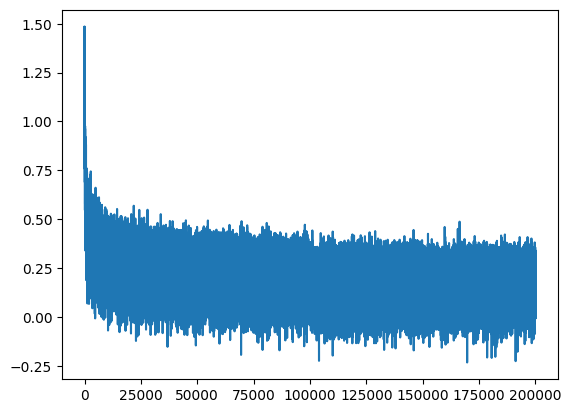

In [89]:
plt.plot(stepi, lossi)

In [90]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4787, grad_fn=<NllLossBackward0>)

In [91]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5425, grad_fn=<NllLossBackward0>)

In [92]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5232, grad_fn=<NllLossBackward0>)

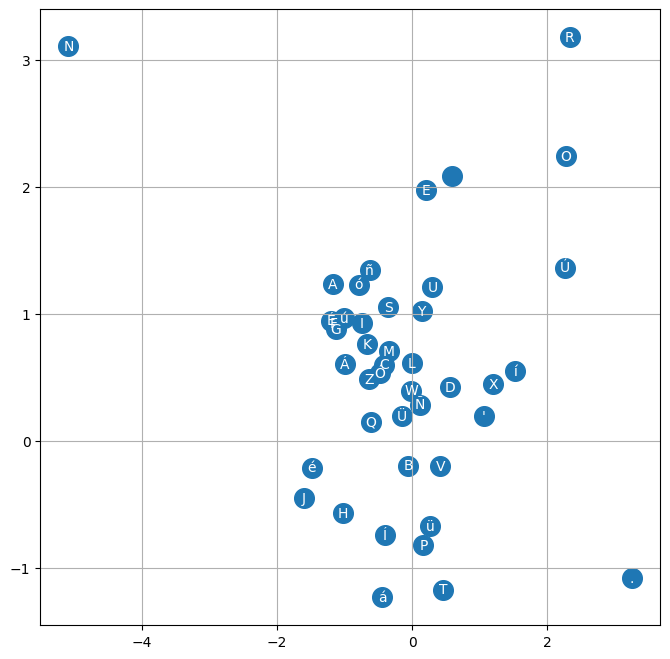

In [93]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [94]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

CRISTIAN MONTSERLY.
MARIA.
CRISA.
CHE.
JYLA.
BAHIMA.
JOSEFANNANDRA.
CARMEN.
VALLENA.
AMARITA.
LHAFJONPE.
FERNACION.
AMARIA.
NOEMISABEL.
ANETBA.
ANGELESCINTISA.
ZAMILAR ROSA.
AIDA MARIA.
MIRA.
MARIA.


# Specific task 2A-I: Multiple models; multiple languages
Pick a second language. Build a second character-level model for this language and assess its quality.

In [95]:
!wget https://raw.githubusercontent.com/estersct/NLP/main/french_names.txt

--2024-03-03 00:06:23--  https://raw.githubusercontent.com/estersct/NLP/main/french_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92844 (91K) [text/plain]
Saving to: ‘french_names.txt.1’

french_names.txt.1  100%[===================>]  90.67K  --.-KB/s    in 0.003s  

2024-03-03 00:06:23 (30.3 MB/s) - ‘french_names.txt.1’ saved [92844/92844]



In [97]:
# Load the French names from the uploaded file
french_file_path = 'french_names.txt'
french_words = open(french_file_path, 'r', encoding='ISO-8859-1').read().splitlines()

# Process the data to create a vocabulary of characters
# Including French-specific characters
french_chars = sorted(list(set(''.join(french_words) + "àâäæçéèêëîïôœùûüÿÀÂÄÆÇÉÈÊËÎÏÔŒÙÛÜŸ")))
stoi_french = {s: i + 1 for i, s in enumerate(french_chars)}
stoi_french['.'] = 0  # Adding a special token for end of name
itos_french = {i: s for s, i in stoi_french.items()}

In [98]:
# Build the dataset with the new French names
block_size = 3  # context length

def build_dataset(french_words):
    X, Y = [], []
    for w in french_words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi_french[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# Splitting the dataset into training, validation, and test sets
random.seed(42)
random.shuffle(french_words)
n1 = int(0.8 * len(french_words))
n2 = int(0.9 * len(french_words))

Xtr_french, Ytr_french = build_dataset(french_words[:n1])
Xdev_french, Ydev_french = build_dataset(french_words[n1:n2])
Xte_french, Yte_french = build_dataset(french_words[n2:])

# Step 4: Initialize parameters for the neural network modifying weights and biases
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_french_chars = len(stoi_french)  # Number of unique characters
C = torch.randn((num_french_chars, 10), generator=g)
W1 = torch.randn((30, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, num_french_chars), generator=g)
b2 = torch.randn(num_french_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters :
    p.requires_grad = True

In [99]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [100]:
# Assuming 'input_tensor' is your input tensor
input_shape = Xtr_french.size()
print("Shape of input tensor:", input_shape)
# Assuming Ytr is your target variable
num_classes = torch.unique(Ytr_french).size(0)
print("Number of classes in the dataset:", num_classes)

Shape of input tensor: torch.Size([64984, 3])
Number of classes in the dataset: 37


In [101]:
for i in range(200000):

  # minibatch construct (double than the Spanish model)
  ix = torch.randint(0, min(Xtr.shape[0], Xtr_french.shape[0], Ytr_french.shape[0]), (64,))

  # forward pass
  emb = C[Xtr_french[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr_french[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update learning rate (decreased)
  #lr = lrs[i]
  lr_french = 0.05 if i < 100000 else 0.005
  for p in parameters :
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

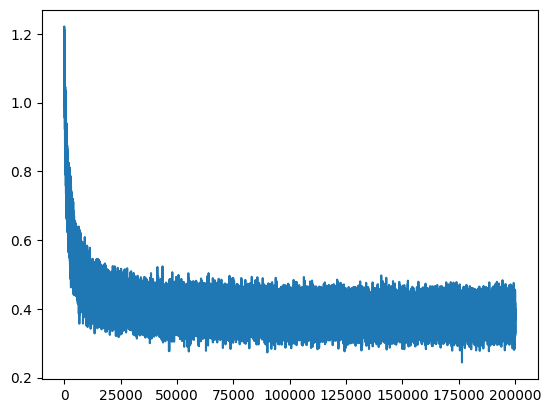

In [102]:
plt.plot(stepi, lossi)

In [103]:
# training loss
emb = C[Xtr_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr_french)
loss

tensor(2.4018, grad_fn=<NllLossBackward0>)

In [104]:
# validation loss
emb = C[Xdev_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev_french)
loss

tensor(2.4329, grad_fn=<NllLossBackward0>)

In [105]:
# test loss
emb = C[Xte_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte_french)
loss

tensor(2.4182, grad_fn=<NllLossBackward0>)

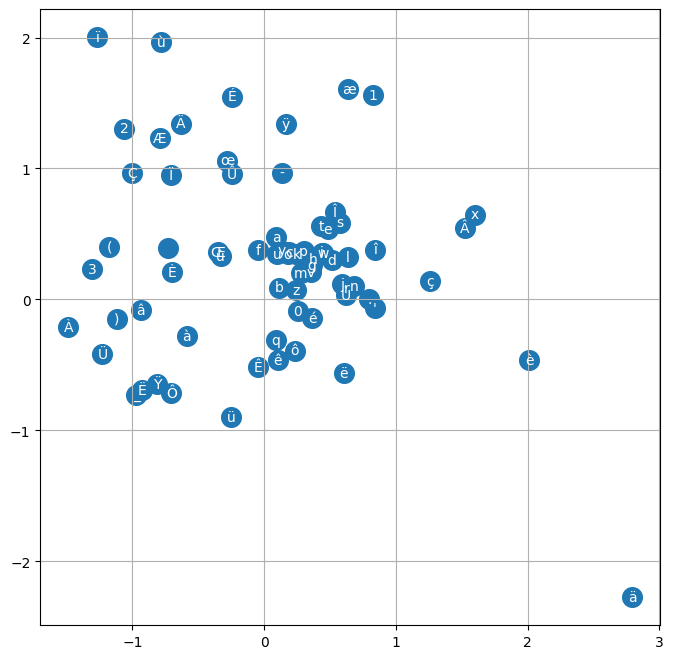

In [106]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos_french[i], ha="center", va="center", color='white')
plt.grid('minor')

In [107]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos_french[i] for i in out))

cherlaco.
perphill.
.
hobint.
johia.
afhata.
stina.
ryb.
kerzonefa.
.
alanyse.
nonda.
jaylievis.
deiphale.
nan.
tol.
adalemerongide.
kerakeus.
lus.
solend.


Then
assess your first model on the task of generating names for the second language, and vice-versa.

In [108]:
# French on Spanish model
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr_french.shape[0], (32,))

  # forward pass
  emb = C[Xtr_french[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr_french[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

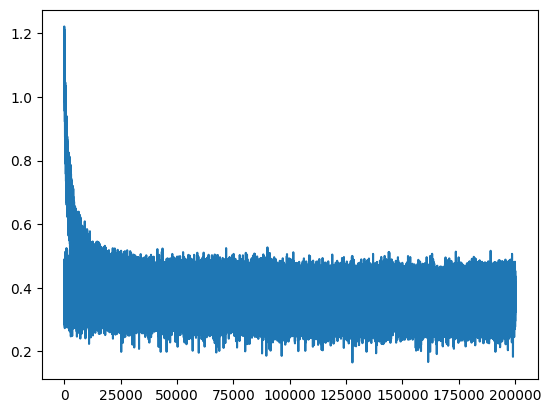

In [109]:
plt.plot(stepi, lossi)

In [110]:
# training loss
emb = C[Xtr_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr_french)
loss

tensor(2.3169, grad_fn=<NllLossBackward0>)

In [111]:
# validation loss
emb = C[Xdev_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev_french)
loss

tensor(2.3790, grad_fn=<NllLossBackward0>)

In [112]:
# test loss
emb = C[Xte_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte_french)
loss

tensor(2.3698, grad_fn=<NllLossBackward0>)

In [113]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos_french[i] for i in out))

ches.
aco.
perphild.
.
hobie.
lachi.
edi.
ber.
ste.
ani.
bristafferd.
.
alfiegenne.
lacolacilans.
deiph.
leina.
coris.
auth.
jalvyndereerekussolmi.
solond.


In [114]:
# Spanish on French model
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_chars = len(stoi)  # Number of unique characters
C = torch.randn((num_chars, 10), generator=g)
W1 = torch.randn((30, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, num_chars), generator=g)
b2 = torch.randn(num_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters :
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [115]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, min(Xtr.shape[0], Ytr.shape[0]), (64,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.05 if i < 100000 else 0.005
  for p in parameters :
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

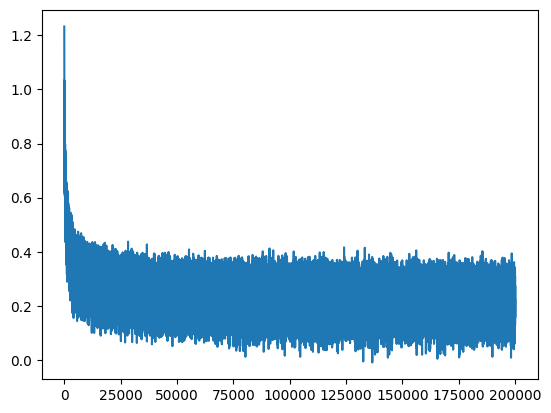

In [116]:
plt.plot(stepi, lossi)

In [117]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.6652, grad_fn=<NllLossBackward0>)

In [118]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.6906, grad_fn=<NllLossBackward0>)

In [119]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.6683, grad_fn=<NllLossBackward0>)

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

CRISTIKE CECICIA.
BADORA.
ROSA ARIANA YOS.
BARABERNGELENA.
MARIA.
CARMA.
NO PUCA.
SAMARIA ALMA BELA.
VICTORIA.
RATMUHANIOVANA MARSIDERABETH POSOROFETITA.
ZILDA.
BLANDA.
AIDA MARIA.
MIRA.
MARIA.
ALRINA.
CIMIA.
NDYNE.
DOLINA.
CARONIYI.
